In [1]:
import retinanalysis as ra
import pandas as pd
import numpy as np
ra.settings.mea_config
import matplotlib.pyplot as plt

# Run below if needing to update the database
# ra.database_pop.reload_celltypefiles()
# ra.database_utils.populate_database()

[2025-07-02 16:01:15,516][INFO]: Connecting root@127.0.0.1:3306
[2025-07-02 16:01:15,611][INFO]: Connected root@127.0.0.1:3306


In [2]:
df = ra.get_datasets_from_protocol_names('matfiles')
df


Found 1 protocols matching "matfiles":
['edu.washington.riekelab.protocols.PresentMatFiles']

Found 1 experiments, 1 epoch blocks.



,exp_name,datafile_name,NDF,chunk_name,protocol_name,is_mea,data_dir,group_label,experiment_id,protocol_id,group_id,block_id,chunk_id
0,20250514C,data003,0.5,movies_images,edu.washington.riekelab.protocols.PresentMatFiles,1,20250514C/data003,PresentMatFiles,138,77,2440,3662,502


In [3]:
s1 = ra.StimBlock(df.at[0, 'exp_name'], df.at[0, 'datafile_name'])
ac1 = ra.AnalysisChunk(df.at[0, 'exp_name'], s1.nearest_noise_chunk)

Loading VCD from /Volumes/Vyom MEA/analysis/20250514C/chunk1/kilosort2.5 ...
VCD loaded with 781 cells.
Loaded spatial maps for channels [0, 2] and 781 cells


(88, 142, 2)

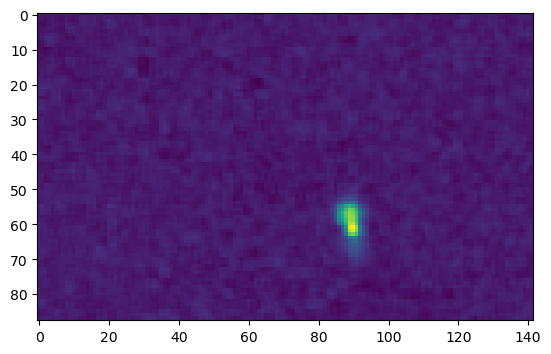

In [4]:
cell_idx = 10
cell_id = ac1.cell_ids[cell_idx]
display(ac1.d_spatial_maps[cell_id].shape)
plt.imshow(ac1.d_spatial_maps[cell_id][:,:,0])

Correlation matrix computation

In [5]:
sm_flat = [sm.flatten() for sm in ac1.d_spatial_maps.values()]
sm_flat = np.array(sm_flat)

ei_flat = [ac1.vcd.get_ei_for_cell(id).ei.flatten() for id in ac1.cell_ids]
ei_flat = np.array(ei_flat)

sm_corr = np.corrcoef(sm_flat)
ei_corr = np.corrcoef(ei_flat)

np.nan_to_num(sm_corr, copy=False, nan = 0, posinf = 0, neginf = 0)
np.nan_to_num(ei_corr, copy=False, nan = 0, posinf = 0, neginf = 0);

/Users/riekelabbackup/opt/anaconda3/envs/mea/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/riekelabbackup/opt/anaconda3/envs/mea/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


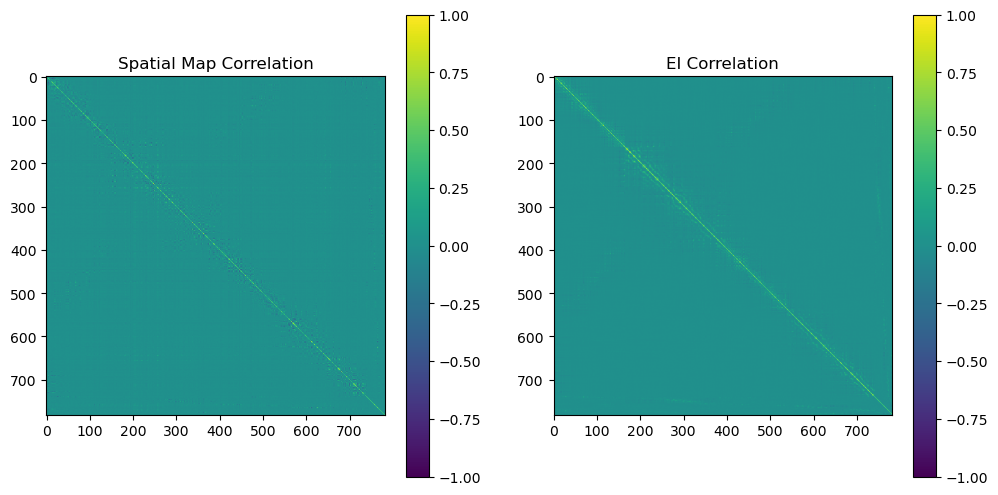

In [6]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
im = axs[0].imshow(sm_corr, cmap='viridis', vmin=-1, vmax=1)
axs[0].set_title('Spatial Map Correlation')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(ei_corr, cmap='viridis', vmin=-1, vmax=1)
axs[1].set_title('EI Correlation')
plt.colorbar(im, ax=axs[1])